In [67]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import scipy.signal as ss
from matplotlib import rc
from astropy import modeling
from photutils.isophote import EllipseGeometry
from photutils import EllipticalAperture
from photutils.isophote import Ellipse
from photutils.isophote import build_ellipse_model
import sys
import multiprocessing
import time
import matplotlib

In [68]:
#plt.rcParams.update({'font.size': 10})
#plt.rc('font', family='serif')
#Formatting

font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 14}

matplotlib.rc('font', **font)

In [69]:
def _identify_pulse(burst_npy, bandwidth=400., centfreq=800., tres=0.020344, plot=True):

    #Load numpy array
    npy = np.load(str(burst_npy))
    
    #Sub-band data
    subfac = 32
    sub = np.nanmean(npy.reshape(-1, subfac, npy.shape[1]), axis=1)
    
    #Smooth Data w Savitzky Golay filter (t - time) (s - spectrum)
    twinlen = sub.shape[1] // 24
    if twinlen % 2 == 0:
        twinlen = twinlen + 1
    swinlen = sub.shape[0] // 8
    if swinlen % 2 == 0:
        swinlen = swinlen + 1
    polyo = 7
    savts_2d = ss.savgol_filter(sub, twinlen, polyo, axis=1)
    savsp_2d = ss.savgol_filter(sub, swinlen, polyo, axis=0)
    print('DYN Time Window Length', twinlen)
    print('DYN Freq Window Length', swinlen)
    
    #Calculate initial guess parameters timeseries - normalized by div by max
    savts = savts_2d.sum(0) / np.max(savts_2d.sum(0))
    maximts = np.max(savts)
    stdts = np.std(savts)
    meants = np.where(savts == maximts)[0][0]
    xts = np.linspace(0, len(savts), len(savts))
    
    #Fit 1D Gaussian to Timeseries
    fitterts = modeling.fitting.LevMarLSQFitter()
    modelts = modeling.models.Gaussian1D(amplitude=maximts, mean=meants, stddev=stdts)
    fitted_modelts = fitterts(modelts, xts, savts)
    
    #Crop pulse to 1/2 pulse width on either side
    pulsewidth = 3 * fitted_modelts.parameters[2] #3sigma
    rcut = int(fitted_modelts.parameters[1] + pulsewidth)
    lcut = int(fitted_modelts.parameters[1] - pulsewidth)
    if rcut >= len(savts):
        rcut = len(savts)
    if lcut <= 0:
        lcut = 0
    print('Crop Time Bin Right', rcut)
    print('Crop Time Bin Left', lcut)
    sav_c = sub[:, lcut:rcut]
    
    #Apply proper units to axes
    nchan = npy.shape[0]
    bw = float(bandwidth) #MHz
    cfreq = float(centfreq) #MHz
    fres = bw / nchan
    print('Frequency Resolution', str(fres) + ' MHz')
    subchan = nchan / subfac
    subfres = bw / subchan
    print('Sub Frequency Resolution', str(subfres) + ' MHz')
    
    #Frequency
    flabel_noend = np.arange(cfreq - bw/2, cfreq+ bw/2, step=round(bw/(2*bw/100)))
    flabels = np.flip(np.append(flabel_noend, [cfreq + bw/2]))
    flabellocs = np.arange(0, sav_c.shape[0], step=round(sav_c.shape[0]/(len(flabels)-1)))#step=sav_c.shape[0]//((2*bw/100)))
    print('FLabel locs: ', flabellocs)
    print('Flables: ', flabels)
    
    #Time
    tbin = sav_c.shape[1]
    tlabellocs = np.arange(0, tbin, step=round(tbin/7))
    #tlabellocs = np.append(tlabellocs, sav_c.shape[1])
    #tlabels_noend = np.arange(0, sav_c.shape[1]*tres, step=round(sav_c.shape[1]*tres/8))
    tlabels = np.arange(0, tbin*tres, step=round((tbin*tres/8)))
    #tlabels = np.append(tlabels_noend [round(sav_c.shape[1]*tres)])
    #tlabels = np.append(tlabels_noend, [round(sav_c.shape[1]*tres)])
    print('TLabel locs: ', tlabellocs)
    print('Tlables: ', tlabels)
    
    #Plot
    if plot == True:
        fig = plt.figure(figsize = (5, 10))
        gs = fig.add_gridspec(4, 1)
        ax1 = fig.add_subplot(gs[-3:, :])
        plt.imshow(sav_c, aspect = 'auto')
        plt.xticks(tlabellocs, tlabels)
        plt.yticks(flabellocs, flabels)
        plt.ylabel('Frequency (MHz)')
        plt.xlabel('Time (ms)')
        ax2 = fig.add_subplot(gs[:1, :])
        plt.plot(xts[lcut:rcut], savts[lcut:rcut], label = 'SavGol TS')
        plt.plot(xts[lcut:rcut], fitted_modelts(xts)[lcut:rcut], label = 'Gauss Fit')
        plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False, labeltop=False)
        plt.title('1D Gaussian Fit')
        plt.legend()
        plt.show()
        fig.savefig('GBT_B_dyn_ts.png')#str(burst_npy) + '_dyn_ts.png')

    #Crop Smoothed Dyn Spec on Both Axes
    savts_2d_c = savts_2d[:, lcut:rcut]
    savsp_2d_c = savsp_2d[:, lcut:rcut]
    
    return npy, savts_2d_c, savsp_2d_c, sav_c, tres, subfres, bw, cfreq

In [70]:
def _prep_2dacf(time_smooth, freq_smooth, time_res, subband_freq_res, diagnostic=True):

    #Calculate 2d acf
    acf2d = ss.correlate(savts_2d_c, savsp_2d_c)

    #Cap spiked central values in acf
    cap = np.mean(acf2d[len(acf2d.sum(1))//2 +10:len(acf2d.sum(1))//2 +10, len(acf2d.sum(0))//2 +10:len(acf2d.sum(0))//2 +10])
    acf2d_cap = np.where(acf2d > cap, cap, acf2d)

    #Smooth Data w Savitzky Golay filter (t - time) (s - spectrum)
    twinlen = acf2d.shape[1] // 12
    if twinlen % 2 == 0:
        twinlen = twinlen + 1
    swinlen = acf2d.shape[0] // 4
    if swinlen % 2 == 0:
        swinlen = swinlen + 1
    polyo = 6
    savacft = ss.savgol_filter(acf2d, twinlen, polyo, axis=1)
    savacff = ss.savgol_filter(acf2d, swinlen, polyo, axis=0)
    print('ACF Time Window Length: ', twinlen)
    print('ACF Freq Window Length: ', swinlen)

    #Calculate initial guess parameters spectrum acf time
    savt = savacft.sum(0) / np.max(savacft.sum(0))
    maximt = np.max(savt)
    stdt = np.std(savt)
    meant = np.where(savt == maximt)[0][0]
    xt = np.linspace(0, len(savt), len(savt))

    #Fit 1D Gaussian to Spectrum
    fittert = modeling.fitting.LevMarLSQFitter()
    modelt = modeling.models.Gaussian1D(amplitude=maximt, mean=meant, stddev=stdt)
    fitted_modelt = fittert(modelt, xt, savt)

    #Calculate initial guess parameters spectrum acf freq
    savsp = savacff.sum(1) / np.max(savacff.sum(1))
    maximsp = np.max(savsp)
    stdsp = np.std(savsp)
    meansp = np.where(savsp == maximsp)[0][0]
    xsp = np.linspace(0, len(savsp), len(savsp))

    #Fit 1D Gaussian to Spectrum
    fittersp = modeling.fitting.LevMarLSQFitter()
    modelsp = modeling.models.Gaussian1D(amplitude=maximsp, mean=meansp, stddev=stdsp)
    fitted_modelsp = fittersp(modelsp, xsp, savsp)

    #Get Ellipse Ratio
    sigmat = fitted_modelt.stddev.value
    sigmaf = fitted_modelsp.stddev.value
    #Up to sig 3 -- MAKE EDIT TO ADJUST ITERATIVELY IN FIT FUNCTION
    sigt1 = sigmat
    sigf1 = sigmaf
    sigt2 = sigmat * 2
    sigf2 = sigmaf * 2
    sigt3 = sigmat * 3
    sigf3 = sigmaf * 3

    sigmat = sigmat * 0.5#(2.355/2)
    sigmaf = sigmaf * 0.5#(2.355/2)

    #Sigmas form a rectangle, get slope of the rectangle diagonal to estimate semi major axis PA
    hyp = np.sqrt(sigmat**2 + sigmaf**2)
    estpa = np.arccos(sigmat / hyp) #in radians

    #Estimate ellipticity (eps) with sigma ratio
    oppestpa = np.arccos(sigmaf / hyp)
    estsmajax = np.tan(oppestpa)*(hyp / 4)
    estsminax = hyp / 4
    esteps = 1 - (estsminax / estsmajax)

    print(estsmajax, estsminax)

    print('Estimated Ellipticity: ', esteps)
    print('Estmated Semimajor Axis: ', estsmajax)
    print('Estimated PA: ', estpa)

    print('Initial guess ellipse applied!')

    #Provide the initial ellipse to be fitted
    #Calculate ellipse geometry
    geometry = EllipseGeometry(x0 = acf2d.shape[1]/2, \
            y0 = acf2d.shape[0]/2, sma = estsmajax, eps = esteps, pa = estpa)
    #Show initial guess ellipse
    aper = EllipticalAperture((geometry.x0, geometry.y0), \
            geometry.sma, geometry.sma*(1-geometry.eps),geometry.pa)

    if diagnostic == True:
        fig = plt.figure()
        plt.imshow(acf2d, aspect = 'auto')
        aper.plot(color='white')
        plt.title('Diagnostic - Pre-fit Estimate')
        plt.show()
        #fig.savefig('Diagnostic_' + str(burst_npy) + '.png')

    print('Now for the fit...')
    
    return acf2d, geometry, aper, sigmat, sigmaf, sigf3

In [71]:
def _fit_ellipse(burst_npy, acf, geometry, aper, sigma_t, sigma_f, bw):

    #Frequency
    
    acfflabel_noend = np.arange(-(cfreq - bw), (cfreq - bw), step=round(bw/(bw/100)))
    acfflabels = np.flip(np.append(acfflabel_noend, [cfreq - bw]))
    acfflabellocs = np.arange(0, acf.shape[0], step=round(acf.shape[0]/(len(acfflabel_noend))))
    #acfflabellocs = np.append(acfflabellocs, acf.shape[0])
    print('ACF Freq. Label Locs: ', acfflabellocs)
    print('ACF Freq. Labels: ', acfflabels)
    
    #Time
    acftbin = acf.shape[1]
    acftlabellocs = np.arange(0, acf.shape[1], step=round(acf.shape[1]/8))
    acftlabellocs = np.append(acftlabellocs, acf.shape[1])
    acftlabels_noend = np.arange(round((-acf.shape[1]/2)*tres), round((acf.shape[1]/2)*tres), step=round(acf.shape[1]*tres/8))
    acftlabels = np.append(acftlabels_noend, [round((acf.shape[1]/2)*tres)])
    print('ACF Time Label Locs: ', acftlabellocs)
    print('ACF Time Labels: ', acftlabels)
    
    #Fit Ellipse to 2D ACF
    try:
        ellipse = Ellipse(acf, geometry)
        isolist = ellipse.fit_image()
        model_image = build_ellipse_model(acf.shape, isolist)
        residual = acf - model_image
    except OverflowError:
        print('Note: Overflow Error')
        pass
    except ValueError:
        print('Note: Value Error')
        pass
    except IndexError:
        print('Ellipse Fit Failed!')
        pass  
    
    return ellipse, isolist, model_image, residual, acfflabels, acfflabellocs, acftlabels, acftlabellocs


In [72]:
def _plot_fit(acf, sav_c, bw, subfres, tres, ellipse, isolist, model_image, residual, acfflabels, acfflabellocs, acftlabels, acftlabellocs, sigmat, simgaf, plot=True):
    
    if plot == True:
        fig = plt.figure(figsize = (8, 8))
        gs = fig.add_gridspec(6, 6)
        ax1 = fig.add_subplot(gs[1:, :5])
        smas = np.linspace(0, int(sigmaf*6), 8)
        xacf = np.linspace(0, acf.shape[1], acf.shape[1])
        yacf = np.linspace(0, acf.shape[0], acf.shape[0])
        for sma in smas:
            iso = isolist.get_closest(sma)
            x, y, = iso.sampled_coordinates()
            xdr = np.linspace(0, acf.shape[1], acf.shape[1])
            slope = np.tan(np.max(isolist.pa))
            print('Slope: ', slope)
            std_sma_dr_unround = np.std(np.tan(isolist.pa))
            std_sma_dr = '%s' % float('%.2g' % std_sma_dr_unround)
            drift_rate_unround = -1 * (slope * (subfres / tres)) #MHz/ms
            dr_std_unround = (std_sma_dr_unround / slope) * drift_rate_unround
            dr_std = '%s' % float('%.2g' % dr_std_unround)
            print('DR STD: ', dr_std)
            drift_rate = '%s' % float('%.4g' % drift_rate_unround) #MHz/ms
            b = 100+(-(float(slope))*acf.shape[1]/2 + acf.shape[0]/2)
            #print('Drift Rate: ', str(drift_rate) + ' +/- ' + str(std_sma_dr) + ' MHz/ms')
            #plt.plot(xdr, dr(xdr, slope=slope+std_sma_dr_unround*.01), c = 'w', linestyle = 'dashdot')
            #plt.plot(xdr, dr(xdr, slope=slope-std_sma_dr_unround*.01), c = 'w', linestyle = 'dashdot')
            plt.imshow(acf, aspect = 'auto')
            plt.plot(x, y, color='white')
        def dr(xdr, slope=slope, b=b):
            return slope*xdr - b #- (slope * round((acf.shape[1]//2)))
        #plt.plot(xdr, dr(xdr), c = 'w', linestyle = 'dotted', label='Cumulative SMA Drift')#label = 'Drift Rate: ' + str(drift_rate) + ' +/- ' + str(dr_std) + ' MHz/ms')
        #plt.plot(xdr, dr(xdr, slope=(float(slope) + float(std_sma_dr)), \
                         #b = 100+(-(float(slope) + float(std_sma_dr))*acf.shape[0]/2 + acf.shape[1]/2)), \
                         #c = 'w', linestyle = 'dashdot', label = '+/- Sigma')
        #plt.plot(xdr, dr(xdr, slope=(float(slope) - float(std_sma_dr)), \
                         #b = -195+((float(slope) - float(std_sma_dr))*acf.shape[0]/2 + acf.shape[1]/2)), \
                         #c = 'w', linestyle = 'dashdot')
        plt.axvline(acf.shape[1]//2 - 3*sigmat, c = 'w', linestyle = 'dashdot')
        plt.axvline(acf.shape[1]//2 + 3*sigmat, c = 'w', linestyle = 'dashdot')
        plt.axhline(acf.shape[0]//2 - 3*sigmaf, c = 'w', linestyle = 'dashdot')
        plt.axhline(acf.shape[0]//2 + 3*sigmaf, c = 'w', linestyle = 'dashdot')
        plt.xticks(acftlabellocs, acftlabels)
        plt.yticks(acfflabellocs, acfflabels)
        plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
        plt.tick_params(axis='y', which='both', left=True, right=False)
        plt.ylabel('Frequency Lag (MHz)')
        plt.xlabel('Time Lag (ms)')
        plt.ylim(acf.shape[0]-1, 0)
        plt.xlim(0, acf.shape[1])
        #plt.legend()
        ax2 = fig.add_subplot(gs[:1, :5])
        plt.plot(xacf, acf.sum(0)/np.max(acf.sum(0)), c = 'k')
        plt.axvline(acf.shape[1]//2 - 3*sigmat, c = 'r', linestyle = 'dashdot', label = '1.5 Sig.')
        plt.axvline(acf.shape[1]//2 + 3*sigmat, c = 'r', linestyle = 'dashdot')
        plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
        plt.tick_params(axis='y', which='both', left=False, right=False)
        plt.xlim(0, acf.shape[1])
        #plt.title('2D ACF Drift Rate: ' + str(drift_rate) + ' +/- ' + str(dr_std) + ' MHz/ms')
        #plt.title('2D ACF Isophote Ellipse Fit | GBT B')
        plt.legend()
        plt.tight_layout()
        ax3 = fig.add_subplot(gs[1:, 5:])
        plt.plot(acf.sum(1)/np.max(acf.sum(1)), yacf, c = 'k')
        plt.axhline(acf.shape[0]//2 - 3*sigmaf, c = 'r', linestyle = 'dashdot')
        plt.axhline(acf.shape[0]//2 + 3*sigmaf, c = 'r', linestyle = 'dashdot')
        plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False, labeltop=True)
        plt.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
        plt.ylim(acf.shape[0]-1, 0)
        plt.show()
        fig.savefig('GBT_B' + '_ellipse_fit.png', dpi = 600)
        fig = plt.figure()
        xdrsav = np.linspace(0, sav_c.shape[1], sav_c.shape[1])
        plt.plot(xdrsav, dr(xdrsav))
        plt.imshow(sav_c, aspect = 'auto')
        plt.show()
    
    print('Fit completed!')
    
    #slope = np.tan(np.max(isolist.pa))
    #std_sma_dr_unround = np.tan(np.std(isolist.pa))
    #std_sma_dr = '%s' % float('%.2g' % std_sma_dr_unround)
    #drift_rate_unround = -1 * (slope * (subfres / tres)) #MHz/ms
    #drift_rate = '%s' % float('%.4g' % drift_rate_unround) #MHz/ms
    #print('Drift Slope: ', str(drift_rate) + ' +/- ' + str(std_sma_dr) + ' MHz/ms')
    
    return drift_rate, std_sma_dr

Text(0.5, 1.0, 'Residual')

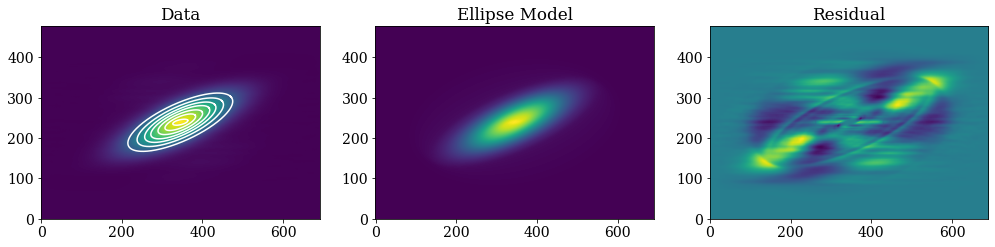

In [73]:
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(14, 5), nrows=1, ncols=3)
fig.subplots_adjust(left=0.04, right=0.98, bottom=0.02, top=0.98)
ax1.imshow(acf2d, origin='lower')
ax1.set_title('Data')

smas = np.linspace(0, int(sigmaf*6), 8)
for sma in smas:
    iso = isolist.get_closest(sma)
    x, y, = iso.sampled_coordinates()
    ax1.plot(x, y, color='white')

ax2.imshow(model_image, origin='lower')
ax2.set_title('Ellipse Model')

ax3.imshow(residual, origin='lower')
ax3.set_title('Residual')

DYN Time Window Length 171
DYN Freq Window Length 31
Crop Time Bin Right 457
Crop Time Bin Left 72
Frequency Resolution 0.052083333333333336 MHz
Sub Frequency Resolution 1.6666666666666667 MHz
FLabel locs:  [  0  30  60  90 120 150 180 210]
Flables:  [1000.  950.  900.  850.  800.  750.  700.  650.  600.]
TLabel locs:  [  0  55 110 165 220 275 330]
Tlables:  [0. 1. 2. 3. 4. 5. 6. 7.]


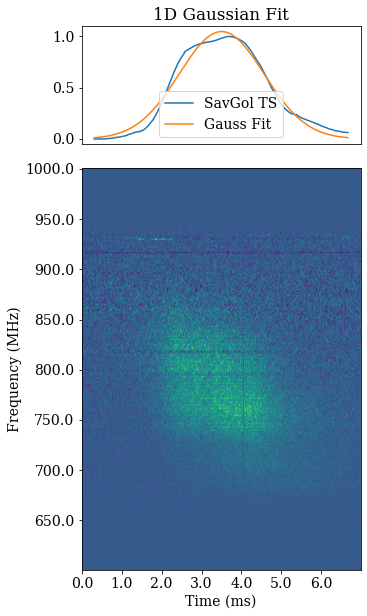

/Users/jakobfaber/.pyenv/versions/3.7.3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/jakobfaber/.pyenv/versions/3.7.3/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


ACF Time Window Length:  65
ACF Freq Window Length:  119
27.94983408627555 12.282258138531441
Estimated Ellipticity:  0.5605606065274461
Estmated Semimajor Axis:  27.94983408627555
Estimated PA:  0.41403710048633274
Initial guess ellipse applied!


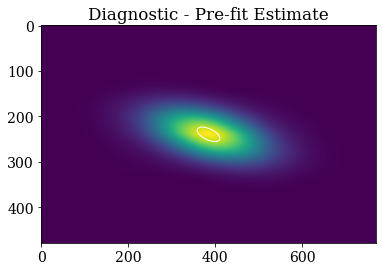

Now for the fit...
Sigma Freq:  19.76503125228611
NPY Shape:  (7680, 4096)


In [74]:
#if __name__ == "__main__":
    #burst_npy = input('Burst Npy File: ')
    #cfreq = input('Center Frequency: ')
    #bandwidth = input('Bandwidth: ')
    
burst_npy = '../scintillation/E_579_dm348.8.fits.npy'
cfreq = 800
bandwidth = 400
npy, savts_2d_c, savsp_2d_c, sav_c, tres, subfres, bw, cfreq = \
        _identify_pulse(burst_npy, bandwidth=bandwidth, \
        centfreq=cfreq, tres=0.020344, plot=True)
acf2d, geometry, aper, sigmat, sigmaf, sigf3 = \
        _prep_2dacf(savts_2d_c, savsp_2d_c, tres, subfres, diagnostic=True)
print('Sigma Freq: ', sigmaf)
print('NPY Shape: ', npy.shape)
#See next cell...
#drift_rate = _fit_ellipse(burst_npy, acf2d, \
#        geometry, aper, sigmat, sigmaf, plot=True)
    
#y = mx + b
#(bw - (slope * round((acf.shape[1]//2)*tres))) =  b

In [75]:
ellipse, isolist, model_image, residual, acfflabels, acfflabellocs, acftlabels, acftlabellocs = \
        _fit_ellipse(burst_npy, acf2d, \
        geometry, aper, sigmat, sigmaf, bw)

ACF Freq. Label Locs:  [  0  60 120 180 240 300 360 420]
ACF Freq. Labels:  [ 400.  300.  200.  100.    0. -100. -200. -300. -400.]
ACF Time Label Locs:  [  0  96 192 288 384 480 576 672 768 769]
ACF Time Labels:  [-8 -6 -4 -2  0  2  4  6  8]


KeyboardInterrupt: 

In [ ]:
_plot_fit(acf2d, sav_c, bw, subfres, tres, ellipse, isolist, model_image, residual, \
          acfflabels, acfflabellocs, acftlabels, acftlabellocs, sigmat, sigmaf, plot=True)